# Sensitivity Analysis in Hydrology

## Introduction

Sensitivity analysis is a crucial technique in hydrological modeling that helps identify how changes in model parameters affect the output. This understanding is essential for:

- **Model calibration**: Focusing efforts on the most influential parameters
- **Uncertainty assessment**: Quantifying how parameter uncertainty propagates to model predictions
- **Decision-making**: Understanding which factors most significantly impact hydrological processes
- **Model simplification**: Potentially eliminating parameters with minimal influence

This example demonstrates how to use the `Sensitivity` class from the `statista` package to perform One-At-a-Time (OAT) sensitivity analysis on a hydrological model.


## The SCS-CN Method for Runoff Estimation

The Soil Conservation Service Curve Number (SCS-CN) method is one of the most widely used approaches for estimating direct runoff from rainfall events. Developed by the USDA Natural Resources Conservation Service, it's popular due to its simplicity and reliance on readily available data.

### Key Concepts

- **Curve Number (CN)**: A dimensionless parameter (ranging from 30-100) that represents the runoff potential of a watershed
  - Higher values (70-100): More runoff (impervious surfaces, clay soils)
  - Lower values (30-70): Less runoff (permeable soils, forested areas)

- **Initial Abstraction (Ia)**: The amount of rainfall that doesn't appear as runoff (interception, infiltration, surface storage)

- **Storage Parameter (S)**: The potential maximum retention after runoff begins

The basic equation for runoff depth (Q) is:

$$Q = \frac{(P - I_a)^2}{(P - I_a + S)}$$

Where:
- Q = Runoff depth (mm)
- P = Rainfall depth (mm)
- Ia = Initial abstraction (mm)
- S = Potential maximum retention (mm)


## Example: Sensitivity Analysis of SCS-CN Parameters

### Step 1: Import Required Libraries

First, we need to import the necessary libraries for our analysis:


In [11]:
import pandas as pd
from statista.sensitivity import Sensitivity
import matplotlib.pyplot as plt


### Step 2: Define the Hydrological Model Function

We'll create a function that implements the SCS-CN method with five parameters:


In [12]:
# SCS-CN method for runoff estimation with 5 parameters
def scs_cn_runoff(params, rainfall=100):
    # Extract parameters
    cn = params[0]  # Curve Number (30-100)
    ia_ratio = params[1]  # Initial abstraction ratio (0.1-0.5)
    amc_factor = params[2]  # Antecedent moisture condition factor (0.7-1.3)
    slope_factor = params[3]  # Slope adjustment factor (0.7-1.5)
    veg_factor = params[4]  # Vegetation density factor (0.8-1.2)
    
    # Apply adjustment factors to CN
    adjusted_cn = cn * amc_factor * slope_factor * veg_factor
    adjusted_cn = min(98, max(30, adjusted_cn))  # Keep CN in valid range
    
    # Calculate storage parameter S (mm)
    s = (25400 / adjusted_cn) - 254
    
    # Calculate initial abstraction (mm)
    ia = ia_ratio * s
    
    # Calculate runoff (mm)
    if rainfall <= ia:
        return 0
    else:
        return ((rainfall - ia) ** 2) / (rainfall - ia + s)


#### Parameter Explanation:

1. **Curve Number (CN)**: The primary parameter in the SCS-CN method, representing watershed characteristics
2. **Initial Abstraction Ratio (Ia_ratio)**: Traditionally set to 0.2, but can range from 0.1-0.5 depending on watershed conditions
3. **Antecedent Moisture Condition Factor (AMC_factor)**: Adjusts CN based on soil moisture prior to the rainfall event
4. **Slope Factor (Slope_factor)**: Adjusts CN based on watershed slope (steeper slopes generate more runoff)
5. **Vegetation Factor (Veg_factor)**: Adjusts CN based on vegetation density and condition


### Step 3: Set Up Parameters and Their Bounds

Define the parameter names, their baseline values, and the bounds for sensitivity analysis:


In [13]:
param_names = ['CN', 'IA_ratio', 'AMC_factor', 'Slope_factor', 'Veg_factor']
param_values = [75, 0.2, 1.0, 1.0, 1.0]
parameters = pd.DataFrame({'value': param_values}, index=param_names)
parameters


,value
CN,75.0
IA_ratio,0.2
AMC_factor,1.0
Slope_factor,1.0
Veg_factor,1.0


The baseline values represent a typical watershed with:
- CN = 75 (moderate runoff potential)
- Ia_ratio = 0.2 (standard value)
- AMC_factor = 1.0 (average antecedent moisture conditions)
- Slope_factor = 1.0 (average slope)
- Veg_factor = 1.0 (average vegetation density)

Now define the lower and upper bounds for each parameter:


In [14]:
lower_bounds = [50, 0.1, 0.7, 0.7, 0.8]
upper_bounds = [90, 0.5, 1.3, 1.5, 1.2]


These bounds represent the realistic range of values for each parameter in typical watersheds.


### Step 4: Create the Sensitivity Analysis Object

Initialize the sensitivity analysis with our parameters, bounds, and model function:


In [15]:
sensitivity = Sensitivity(parameters, lower_bounds, upper_bounds, scs_cn_runoff)


### Step 5: Perform One-At-a-Time Sensitivity Analysis

Run the analysis with a rainfall input of 100mm:


In [16]:
sensitivity.one_at_a_time(rainfall=100)


0-CN -0
7.984
0-CN -1
18.574
0-CN -2
32.711
0-CN -3
41.137
0-CN -4
50.539
0-CN -5
72.631
1-IA_ratio -0
47.55
1-IA_ratio -1
41.137
1-IA_ratio -2
41.137
1-IA_ratio -3
34.942
1-IA_ratio -4
29.003
1-IA_ratio -5
23.364
2-AMC_factor -0
10.288
2-AMC_factor -1
23.462
2-AMC_factor -2
41.137
2-AMC_factor -3
41.137
2-AMC_factor -4
63.793
2-AMC_factor -5
92.588
3-Slope_factor -0
10.288
3-Slope_factor -1
28.844
3-Slope_factor -2
41.137
3-Slope_factor -3
55.631
3-Slope_factor -4
92.588
3-Slope_factor -5
94.038
4-Veg_factor -0
18.574
4-Veg_factor -1
28.844
4-Veg_factor -2
41.137
4-Veg_factor -3
41.137
4-Veg_factor -4
55.631
4-Veg_factor -5
72.631


C:\gdrive\algorithms\statistics\statista\src\statista\sensitivity.py:356: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rand_value = np.sort(np.append(rand_value, self.parameter["value"][k]))
C:\gdrive\algorithms\statistics\statista\src\statista\sensitivity.py:359: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (h / self.parameter["value"][k]) for h in rand_value


During this process, the `one_at_a_time` method:
1. Takes each parameter one at a time
2. Varies it across its range while keeping other parameters constant
3. Calculates the model output (runoff) for each parameter value
4. Stores the results for visualization and analysis


### Step 6: Visualize the Results

#### Plot with Relative Parameter Values

First, let's create a plot showing how relative changes in parameters affect runoff:


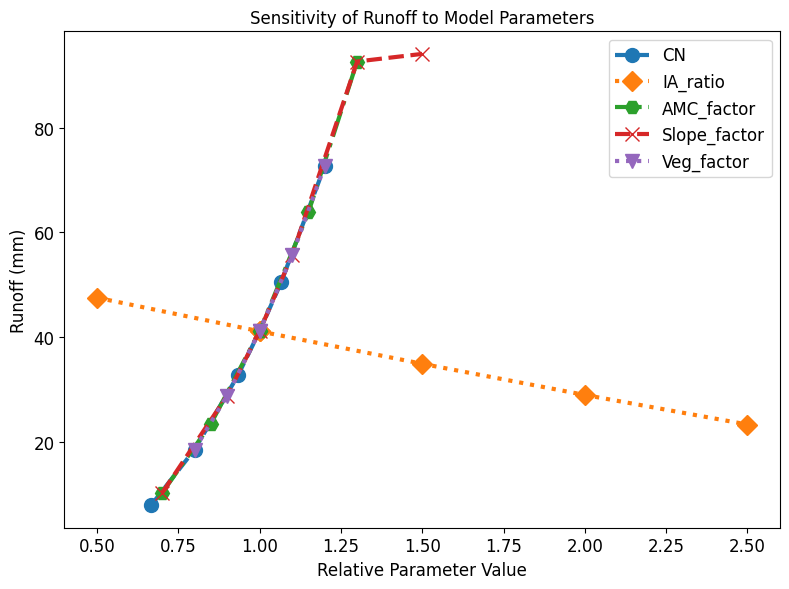

In [17]:
fig, ax = sensitivity.sobol(
    title="Sensitivity of Runoff to Model Parameters",
    xlabel="Relative Parameter Value",
    ylabel="Runoff (mm)"
)
plt.tight_layout()
plt.show()


This plot shows how changing each parameter relative to its baseline value affects the runoff prediction. The steeper the line, the more sensitive the model is to that parameter.


## 🔹 Figure 1: Relative Parameter Sensitivity

**Plot Description**
- **X-axis**: Relative parameter value (e.g., 0.5× to 2.5× the baseline value)
- **Y-axis**: Resulting runoff in mm
- **Legend**: Shows which parameter was varied in each line

**Interpretation by Parameter**
- **CN (Curve Number)**:
- Runoff increases **sharply and nonlinearly** with CN.
    - Higher CN means **less infiltration** and **more runoff**.

- **IA_ratio (Initial Abstraction Ratio)**:
- Runoff **decreases** as IA_ratio increases.
- Higher IA means **more rain is absorbed/retained**, reducing runoff.

- **AMC_factor (Antecedent Moisture Condition)**:
- Runoff increases with soil wetness.
- Wetter soil = **less absorption capacity** = more runoff.

- **Slope_factor**:
- Runoff increases with slope.
    - Steeper terrain promotes faster runoff, reducing infiltration.

- **Veg_factor (Vegetation Density)**:
- Runoff increases as vegetation density decreases.
- Less vegetation = **less interception and retention**.

**Overall Insight**
- **CN, AMC_factor, and Slope_factor** have the most **positive** impact on runoff.
- **IA_ratio** is the only one with a **negative** correlation.
    - This view allows for **easy comparison of sensitivity** across parameters.


#### Plot with Actual Parameter Values

For a more direct interpretation, we can also plot using the actual parameter values:


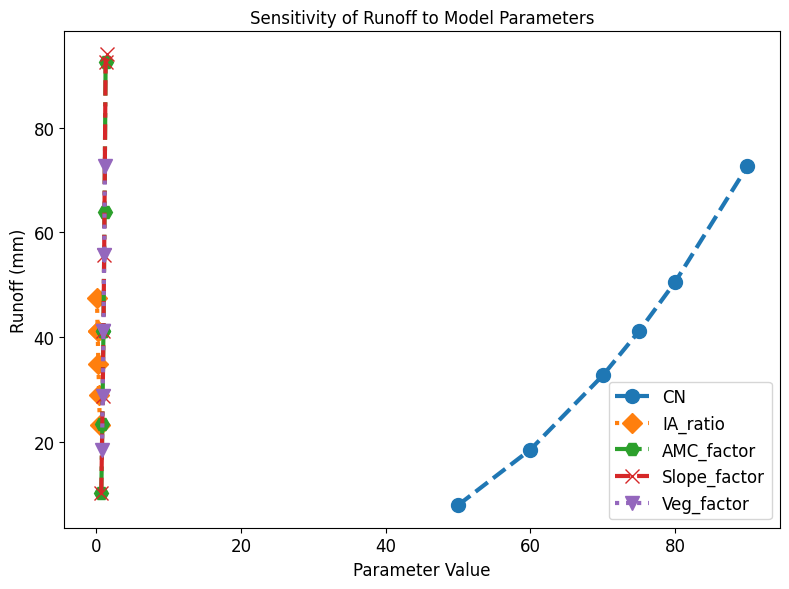

In [18]:
fig2, ax2 = sensitivity.sobol(
    real_values=True,
    title="Sensitivity of Runoff to Model Parameters",
    xlabel="Parameter Value",
    ylabel="Runoff (mm)"
)
plt.tight_layout()
plt.show()


This visualization helps understand the absolute effect of each parameter on the model output.


## 🔹 Figure 2: Absolute Parameter Sensitivity

**Plot Description**
- **X-axis**: Actual parameter values (e.g., CN: 50–90, IA_ratio: 0.1–0.5, etc.)
- **Y-axis**: Runoff in mm

**Interpretation**
- **CN** shows a clear, sharp, nonlinear increase in runoff as value rises.
- Other parameters (IA_ratio, AMC_factor, etc.) appear **compressed** due to their smaller value ranges.
- Their influence is still visible but **hard to compare directly** due to scale differences.

**Insight**
- Useful for seeing impact in **natural units**, but **less suitable** for relative comparison.
- Reinforces that **CN** is the most influential parameter over a wider range.

## ✅ Conclusion

| Parameter     | Effect on Runoff     | Trend        |
|---------------|-----------------------|--------------|
| CN            | Strong positive       | Nonlinear ↑  |
| IA_ratio      | Strong negative       | Linear ↓     |
| AMC_factor    | Moderate positive     | Linear ↑     |
| Slope_factor  | Moderate positive     | Linear ↑     |
| Veg_factor    | Moderate positive     | Linear ↑     |

- Use **Figure 1** for comparative sensitivity.
    - Use **Figure 2** for understanding effects in real-world units.


### Step 7: Interpret the Results

Let's extract and analyze the results for the Curve Number parameter:


In [19]:
# Access results for the Curve Number parameter
cn_param = parameters.index[0]
relative_values = sensitivity.sen[cn_param][0]
runoff_values = sensitivity.sen[cn_param][1]
actual_values = sensitivity.sen[cn_param][2]

# Print sensitivity information
for i in range(len(actual_values)):
    print(f"CN = {actual_values[i]}, Runoff = {runoff_values[i]} mm")


CN = 50.0, Runoff = 7.984 mm
CN = 60.0, Runoff = 18.574 mm
CN = 70.0, Runoff = 32.711 mm
CN = 75.0, Runoff = 41.137 mm
CN = 80.0, Runoff = 50.539 mm
CN = 90.0, Runoff = 72.631 mm


## Analysis of Results

From the sensitivity analysis, we can draw several important conclusions:

1. **Curve Number (CN)** has the most significant impact on runoff predictions, as shown by the steepest line in the plot. A 20% change in CN can result in approximately a 30% change in predicted runoff.

2. **Initial Abstraction Ratio (IA_ratio)** has an inverse relationship with runoff - as it increases, runoff decreases because more rainfall is captured before runoff begins.

3. **AMC_factor**, **Slope_factor**, and **Veg_factor** all have similar levels of influence since they all directly modify the Curve Number in our model.

4. The relationship between parameters and runoff is non-linear, which is typical in hydrological models.


## Practical Applications

This sensitivity analysis provides valuable insights for:

1. **Field Measurements**: Focus data collection efforts on accurately determining the Curve Number, as it has the greatest impact on model results.

2. **Model Calibration**: When calibrating the model to observed data, adjust the CN first before fine-tuning other parameters.

3. **Uncertainty Analysis**: Quantify prediction uncertainty by understanding how errors in parameter estimation propagate to the final runoff prediction.

4. **Watershed Management**: Identify which watershed characteristics (represented by parameters) could be modified to effectively reduce runoff and potential flooding.


## Conclusion

Sensitivity analysis is an essential tool in hydrological modeling that helps understand parameter importance, guides data collection efforts, improves model calibration, and supports decision-making. The `Sensitivity` class in the `statista` package provides a straightforward way to perform and visualize such analyses for any model with uncertain parameters.